In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from conv2d import Conv2D

In [6]:
image = mpimg.imread('fig.png')
# make image smaller (faster execution) and change format from [0,1] to [0,255]
image = (image[::4,::3])

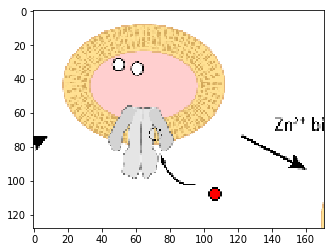

In [7]:
plt.imshow(image)
plt.show()

In [12]:
import numpy as np

def max_pool(data,step_size):
    '''Max pool data and reduce the number of pixels'''
    # setup parameters
    n,x,y = data.shape
    # generate output array
    pool = np.zeros((n,x//step_size,y//step_size))
    # reduce size
    for k in range(n):
        # for each kernel
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size):
                pool[k,i//step_size,j//step_size] = np.max(data[k,i:i+step_size,j:j+step_size])
    return pool

def d_max_pool(delta, data, step_size):
    '''
    delta of the next layer (feeding backward into the max pool, weighted and after reshaping)
        original data used during the feed forward
    '''
    # output array
    n,x,y = data.shape
    error = np.zeros(data.shape)
    # loop through x,y and kernel
    for k in range(n):
        for i in range(0,x-x%step_size,step_size):
            for j in range(0,y-y%step_size,step_size): 
                # obtain index of largest value in input for current window
                current = data[k,i:i+step_size, j:j+step_size]
                (a, b) = np.unravel_index(np.argmax(current),current.shape)
                # update error to propagate backward (only the max value is propagated)
                error[k,i+a, j+b] = delta[k,i//step_size, j//step_size]        
                # no weights to update
    return error

In [13]:
n = 3
conv = Conv2D(n,3)
conv.initialize_weights()
relu_conv = conv.feed_forward(image)

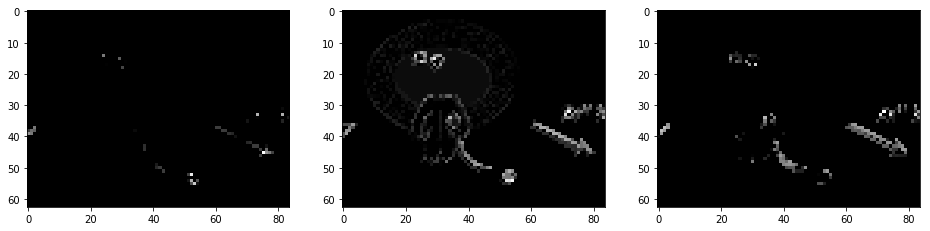

In [14]:
pool = max_pool(relu_conv,2)
#dpool = d_max_pool(pool,relu,2) # dummy test (pool is not the deltas)
#a,b,c = d_convolve(dpool,image,kernels)
fig, axes = plt.subplots(figsize=(16,12),ncols=n)
for i in range(n):
    axes[i].imshow(pool[i],cmap='gray')    
plt.show()